In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import geodatasets
from datetime import datetime
import nltk
from wordcloud import WordCloud

c:\Users\seanm\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# Load in the cleaned data from the data preprocessing step
df = pd.read_csv('../data/Cleaned_Inspection_Data.csv')

In [3]:
df.head(3)

,restaurant_id,restaurant_name,borough,zipcode,cuisine_description,inspection_date,action_taken,violation_code,violation_description,critical_flag,score,inspection_type,latitude,longitude,borough_block_lot,neighborhood_tabulation_area,inspection_id,grade
0,50143760,88 CANTEEN,Queens,11355,Chinese,2024-12-30,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,12,Cycle Inspection / Initial Inspection,40.744133,-73.825739,4063780041,QN62,62342,A
1,40378212,CUCHIFRITOS,Manhattan,10029,Spanish,2024-06-03,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,28,Cycle Inspection / Initial Inspection,40.798286,-73.940864,1016430044,MN34,47344,Not A
2,41647764,PAN UGO BAKERY,Queens,11421,Bakery Products/Desserts,2022-10-06,Violations were cited in the following area(s).,02B,Hot TCS food item not held at or above 140 °F.,Critical,50,Cycle Inspection / Initial Inspection,40.692470,-73.859386,4089190034,QN53,13150,Not A


# Feature Engineering and Exploratory Data Analysis

Recall that we are trying to predict inspection grades for future inspections.  That means that when we make a prediction for a future inspection, we will not be able to know the results of that inspection before it occurs.  Many of the features in our dataset are the results of an inspection.  What we *can* know are the results of *past* inspections.  Thus, we will have to transform many of our features about current inspections into summaries of past inspections for a particular window of years into the past.  We will engineer one feature at a time, in a step by step process. We will only explore the data after we have engineered all the features, as it will look very different after the feature engineering. 

We also know that, since we will be predicting future inspection results (1 row per future inspection) we also need our training data to have 1 row per inspection.  Thus, we will have to group our features by the inspection ID that we created last time.  In essence, throughout this notebook, we will have two dataframes being used in tandem.  Our source will be the cleaned data we just loaded in.  However, we will be pulling from it and manipulating it to generate an entirely new dataframe - the data that will be used for modeling.  We will call this dataframe df_mod, for modeling.

We will begin by creating our df_mod, which will simply start with four columns: the inspection ID, the restaurant ID, the score, and the grade.  Though the ID columns will eventually not be included in modeling, we will need them to add columns to our modeling data through joins.  We will join other inspection-level features into this dataframe as we engineer them.

In [4]:
# Create the inspection-level df_mod dataframe
df_mod = df.groupby(['restaurant_id','inspection_id']).agg(
    score=('score','median'),
    grade=('grade',pd.Series.mode)
).reset_index()
df_mod.head(3)

,restaurant_id,inspection_id,score,grade
0,30075445,19604,21.0,Not A
1,30075445,19949,13.0,A
2,30075445,31067,38.0,Not A


First, we would like to find some way to extract information from the restaurant name.  It will not be advisable to leave this feature as-is, simply because it would introduce way too many features into our training data.  Intuitively, it makes sense that there might be some difference with respect to inspection scores for chains versus non-chains.  Let's explore that here.  Let's first look at the distribution of inspection scores by the number of distinct restaurants associated with a restaurant name.  If this looks promising, we can create a chain indicator and view the distribution of scores along that dimension.  If there is differentiation, we will add the chain indicator to our modeling dataframe.

In [5]:
# Add a column to our original df indicating how many distinct restaurants there were for a given restaurant name
num_restaurants = df.groupby('restaurant_name')['restaurant_id'].nunique().reset_index().rename(columns={'restaurant_id':'num_restaurants'})
df = pd.merge(df,num_restaurants,on='restaurant_name',how='left')

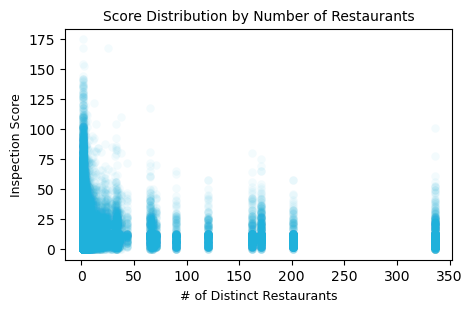

In [6]:
# Group the dataframe to view results by inspection
grouped = df.groupby('inspection_id')[['num_restaurants','score']].median()
# View the distribution of scores versus the number of distinct restaurants
plt.figure(figsize=(5,3))
sns.scatterplot(data=grouped,x='num_restaurants',y='score',alpha=.05,color='#1fb1db',linewidth=0)
plt.title('Score Distribution by Number of Restaurants',fontsize=10)
plt.xlabel('# of Distinct Restaurants',fontsize=9)
plt.ylabel('Inspection Score',fontsize=9)
plt.show()

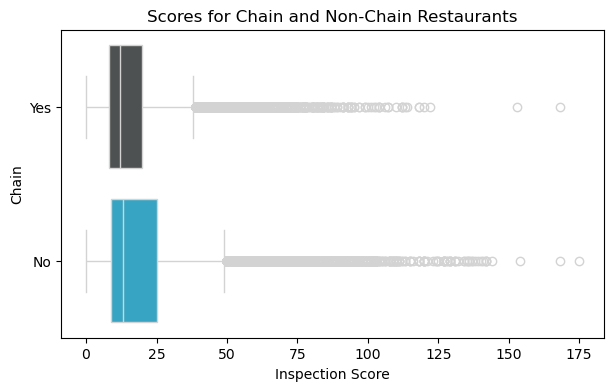

In [7]:
# Create an indicator for a restaurant chain (>1 restaurants) and view the score distribution
df['is_chain'] = df['num_restaurants'].apply(lambda x: 'Yes' if x>1 else 'No')
# Group the dataframe to see results per inspection
grouped = df.groupby('inspection_id').agg(
    is_chain=('is_chain',pd.Series.mode),
    score=('score','median')
)
# Create the boxplot
plt.figure(figsize=(7,4))
sns.boxplot(data=grouped,
            x='score',
            y='is_chain',
            hue='is_chain',
            palette=['#4e5151','#1fb1db'],
            linewidth=1,
            linecolor='lightgray')
plt.title('Scores for Chain and Non-Chain Restaurants')
plt.xlabel('Inspection Score')
plt.ylabel('Chain')
plt.show()

We do see that there is some differentiation.  The boxplot seems to indicate that, in general, chain restaurants tend to do a bit better on inspections (lower scores).  Thus, let's add the chain restaurant indicator to our modeling data.

In [8]:
# Add the chain restaurant indicator to our modeling data
chains_grouped = df.groupby('inspection_id')['is_chain'].agg(pd.Series.mode)
df_mod = pd.merge(df_mod,chains_grouped,on='inspection_id',how='left')
df_mod.head(3)

,restaurant_id,inspection_id,score,grade,is_chain
0,30075445,19604,21.0,Not A,No
1,30075445,19949,13.0,A,No
2,30075445,31067,38.0,Not A,No


The next column to turn our attention to is the cuisine description.  Since there are many unique levels in this column, we will have to find some way to group them together in a way that is useful for our model.  Let's first sort the cuisine types in descending order of the most inspections.  Then, we will take the ten most popular types and leave them as-is.  We will take the remaining cuisine types and group them as 'Cultural Other', 'Non-Meal/Snacks/Desserts', 'Food Groups/Dietary/Breakfast' and 'Other'.  We can then view the distribution of inspection grades with a countplot for each group and see if there is differentiation, or any patterns that might warrant further binning.

In [9]:
# Group the cuisine description and grade to an inspection-level
grouped = df.groupby('inspection_id').agg(
    cuisine_description=('cuisine_description',pd.Series.mode),
    grade=('grade',pd.Series.mode)
)
# Sort the cuisines by their number of inspections
unique_cuisines = grouped['cuisine_description'].value_counts()
# Add the ten most popular to our mapping dict
cuisine_mapping = {}
for cuisine_type in list(unique_cuisines[:10].index):
    cuisine_mapping[cuisine_type] = cuisine_type
# Create the list of values for each of our other cuisine types
cultural_other = [
    'Spanish',
    'Hamburgers',
    'Asian/Asian Fusion',
    'Korean',
    'Thai',
    'Jewish/Kosher',
    'Tex-Mex',
    'Indian',
    'Mediterranean',
    'French',
    'Middle Eastern',
    'Irish',
    'Greek',
    'Eastern European',
    'Southeast Asian',
    'Bangladeshi',
    'African',
    'Peruvian',
    'Steakhouse',
    'New American',
    'Turkish',
    'Fusion',
    'Soul Food',
    'Barbecue',
    'Russian',
    'Filipino',
    'Chinese/Japanese',
    'Continental',
    'Pakistani',
    'Hawaiian',
    'Tapas',
    'Brazilian',
    'Australian',
    'Creole',
    'German',
    'Hotdogs/Pretzels',
    'Hotdogs',
    'Polish',
    'Chinese/Cuban',
    'Moroccan',
    'Ethiopian',
    'English',
    'Afghan',
    'Egyptian',
    'Cajun',
    'Indonesian',
    'Portuguese',
    'New French',
    'Armenian',
    'Creole/Cajun',
    'Lebanese',
    'Scandinavian',
    'Californian',
    'Iranian',
    'Southwestern',
    'Basque',
    'Chilean',
    'Czech',
    'Haute Cuisine',
    'Chimichurri'
]
non_meal = [
    'Donuts',
    'Juice, Smoothies, Fruit Salads',
    'Frozen Desserts',
    'Bagels/Pretzels',
    'Bottled Beverages',
    'Fruits/Vegetables',
    'Nuts/Confectionary'
]
food_groups_dietary_breakfast = [
    'Chicken',
    'Sandwiches',
    'Seafood',
    'Sandwiches/Salads/Mixed Buffet',
    'Salads',
    'Vegan',
    'Pancakes/Waffles',
    'Vegetarian',
    'Soups/Salads/Sandwiches',
    'Soups'
]
other = [
    'Other',
    'Not Listed/Not Applicable'
]
# Complete the cuisine mapping for the groups we just made
extra_categories = {
    'Cultural Other': cultural_other,
    'Non-Meal/Snacks/Desserts': non_meal,
    'Food Groups/Dietary/Breakfast': food_groups_dietary_breakfast,
    'Other': other
}
for cat_label,cuisine_list in extra_categories.items():
    for cuisine in cuisine_list:
        cuisine_mapping[cuisine] = cat_label

In [10]:
# Use our mapping to generate a cuisine group column
df['cuisine_group'] = df['cuisine_description'].map(cuisine_mapping)
# Ensure that the mapping worked correctly
df['cuisine_group'].value_counts()

cuisine_group
Cultural Other                   64720
American                         42422
Chinese                          27234
Coffee/Tea                       18717
Food Groups/Dietary/Breakfast    18496
Pizza                            16378
Non-Meal/Snacks/Desserts         16188
Latin American                   12047
Mexican                          11223
Bakery Products/Desserts         10865
Caribbean                        10073
Japanese                          9660
Italian                           9069
Other                             2809
Name: count, dtype: int64

In [11]:
# Group the cuisine group and grade to the inspection level
grouped = df.groupby('inspection_id').agg(
    cuisine_group=('cuisine_group',pd.Series.mode),
    grade=('grade',pd.Series.mode)
)

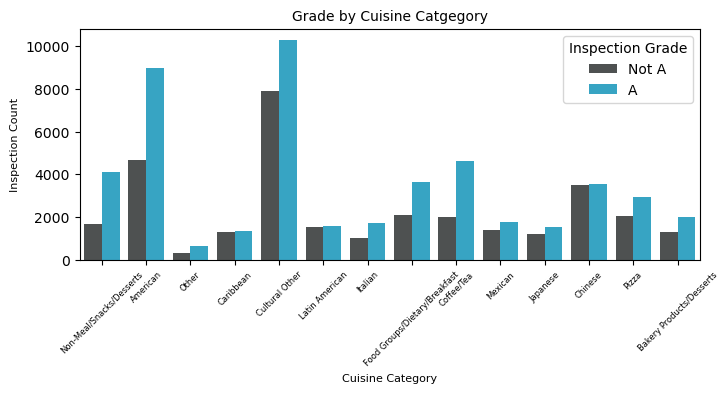

In [12]:
# Generate the countplot 
plt.figure(figsize=(8,3))
sns.countplot(data=grouped,x='cuisine_group',hue='grade',palette=['#4e5151','#1fb1db'])
plt.xticks(rotation=45,fontsize=6)
plt.title('Grade by Cuisine Catgegory',fontsize=10)
plt.xlabel('Cuisine Category',fontsize=8)
plt.ylabel('Inspection Count',fontsize=8)
plt.legend(title='Inspection Grade')
plt.show()

The countplot looks generally satisfactory.  However, several categories can likely be grouped together since they have similar (enough) inspection grade tendencies and cuisine categories.  These will be non-meal eateries, dessert locations, cafes, special food group/dietary eateries, and bakeries.  We can include them in 'Other' for now.

In [13]:
# Change the cuisine group to 'Other' for the groups mentioned above
df['cuisine_group'] = df['cuisine_group'].apply(lambda x: 'Other' if x in ['Non-Meal/Snacks/Desserts',
                                                                           'Food Groups/Dietary/Breakfast',
                                                                           'Coffee/Tea',
                                                                           'Bakery Products/Desserts'] else x)
# Check that this was done correctly
df['cuisine_group'].value_counts()

cuisine_group
Other             67075
Cultural Other    64720
American          42422
Chinese           27234
Pizza             16378
Latin American    12047
Mexican           11223
Caribbean         10073
Japanese           9660
Italian            9069
Name: count, dtype: int64

This feature is now all set, so we can add it to our modeling data.

In [14]:
# Add the cuisine groups into our modeling data
cuisines_grouped = df.groupby('inspection_id')['cuisine_group'].agg(pd.Series.mode)
df_mod = pd.merge(df_mod,cuisines_grouped,on='inspection_id',how='left')
df_mod.head(3)

,restaurant_id,inspection_id,score,grade,is_chain,cuisine_group
0,30075445,19604,21.0,Not A,No,Other
1,30075445,19949,13.0,A,No,Other
2,30075445,31067,38.0,Not A,No,Other


Let's next check to see if there is any pattern to how the inspection score changes over time.

In [15]:
# Extract the yearmonth from the inspection date and find the average score by yearmonth
df['inspection_date'] = pd.to_datetime(df['inspection_date'])
df['inspection_yearmonth'] = df['inspection_date'].dt.strftime('%Y-%m')
by_yrmonth = df.groupby(['inspection_yearmonth','inspection_id'])['score'].mean().reset_index()
by_yrmonth = by_yrmonth.groupby('inspection_yearmonth')['score'].mean().reset_index()

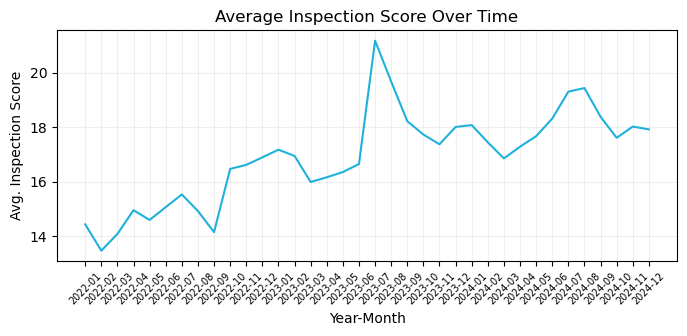

In [16]:
# Filter to 2022-2024 and create a lineplot for the average score by month for these three years
data = by_yrmonth[by_yrmonth['inspection_yearmonth'].str.startswith(('2022','2023','2024'))]
plt.figure(figsize=(8,3))
sns.lineplot(data=data,x='inspection_yearmonth',y='score',color='#1fb1db')
plt.title('Average Inspection Score Over Time')
plt.xlabel('Year-Month')
plt.xticks(rotation=45,fontsize=7)
plt.ylabel('Avg. Inspection Score')
plt.gca().xaxis.grid(True,alpha=.2)
plt.gca().yaxis.grid(True,alpha=.2)
plt.show()

There does not appear to be any definitive seasonality to the inspection scores over time.  Thus, we will be able to drop the inspection date feature when the time comes to build our models.  However, since we will be splitting our training data on time, we will keep it for now just for that purpose.

In [17]:
# Add the inspection yearmonth into our modeling data
dates = df.groupby('inspection_id')['inspection_date'].agg(pd.Series.mode)
df_mod = pd.merge(df_mod,dates,on='inspection_id',how='left')
df_mod.head(3)

,restaurant_id,inspection_id,score,grade,is_chain,cuisine_group,inspection_date
0,30075445,19604,21.0,Not A,No,Other,2023-01-31
1,30075445,19949,13.0,A,No,Other,2023-02-03
2,30075445,31067,38.0,Not A,No,Other,2023-08-01


## Feature Engineering with Window Functions

Next, let's move to some of the inspection result columns.  We will start with the action taken column.  Let's use a window function to generate an indicator for whether a restaurant has been closed in the past two years.  But first, we will check that there is only one unique action taken per inspection.  If not, we will have to manipulate the data to make it so.

In [18]:
# Obtain a list of the inspection IDs that had multiple unique action_taken entries
actions = df.groupby('inspection_id')['action_taken'].nunique()
actions = actions[actions>1]
multi_ids = list(actions.index)

In [19]:
# Look at a few examples
for id in multi_ids[:5]:
    filtered = df[df['inspection_id']==id]
    unique_actions = filtered['action_taken'].unique()
    print(f'{id}: {unique_actions}\n')

3407: ['Violations were cited in the following area(s).'
 'No violations were recorded at the time of this inspection.']

4954: ['Violations were cited in the following area(s).'
 'No violations were recorded at the time of this inspection.']

5210: ['Violations were cited in the following area(s).'
 'No violations were recorded at the time of this inspection.']

5272: ['Violations were cited in the following area(s).'
 'No violations were recorded at the time of this inspection.']

5879: ['Violations were cited in the following area(s).'
 'No violations were recorded at the time of this inspection.']



In [20]:
# Double check that this is the pattern for all these inspections
pattern = set(['Violations were cited in the following area(s).',
           'No violations were recorded at the time of this inspection.'])
for id in multi_ids:
    filtered = df[df['inspection_id']==id]
    unique_actions = set(filtered['action_taken'].unique())
    if unique_actions!=pattern:
        print(f'{id}')

In [21]:
# Remove the problematic 'no violations' rows for these inspections
total_dropped = 0
for id in multi_ids:
    before = len(df)
    df = df.loc[~((df['inspection_id']==id) & (df['action_taken']=='No violations were recorded at the time of this inspection.'))]
    after = len(df)
    dropped = before-after
    total_dropped += dropped
print(f'Total dropped: {total_dropped}')

Total dropped: 37


In [22]:
# Double check that this matches the length of multi_ids
len(multi_ids)

37

Unfortunately, there were a few problematic rows.  Fortunately, they have been taken care of, assuming that when there are violations cited for an inspection it cannot be the case that no violations were found.  In all, 37 rows were dropped.  Now we can move on to setting up the window function.

In [23]:
# Set up our data for the window function
window = df.groupby('inspection_id').agg(
    restaurant_id=('restaurant_id','median'),
    action_taken=('action_taken',pd.Series.mode),
    inspection_date=('inspection_date',pd.Series.mode)
).reset_index()
window = window.set_index('inspection_date')

In [24]:
# Generate an indicator for whether the inspection resulted in a closing
closing_actions = [
    'Establishment re-closed by DOHMH.',
    'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.'
]
window['closed'] = window['action_taken'].apply(lambda x: 1 if x in closing_actions else 0)

In [25]:
# Use .rolling() to indicate if the restaurant has closed within 2 years for a given inspection (not including the current inspection)
rolling_ind = window.groupby('restaurant_id')['closed'].rolling('730d',closed='left').sum().fillna(0).rename('closed_past_two_years')
# Reset the index
rolling_ind = rolling_ind.reset_index()

In [26]:
# Join the indicator to our modeling data on the restaurant id and inspection date
df_mod = pd.merge(left=df_mod,right=rolling_ind,on=['restaurant_id','inspection_date'],how='left')

Let's now turn our attention to violation counts themselves.  Let's use another window function to add a column that tells us how many violations a given restaurant has had per inspection in the past two years.  We will want to leave null values as nulls this time for now, though we may be able to encode them as -1 to preserve a semi-numeric data type in the column.  We could then ordinally encode this feature before modeling.

In [27]:
# Impute 'Not Applicable' codes as nulls so they do not get counted when aggregating
nulls_imputed = df.copy()
nulls_imputed.loc[nulls_imputed['violation_code']=='Not Applicable','violation_code'] = pd.NA

In [28]:
# Obtain the violation counts per inspection ID
violation_counts = nulls_imputed.groupby('inspection_id').agg(
    restaurant_id=('restaurant_id','median'),
    violation_count=('violation_code','count'),
    inspection_date=('inspection_date',pd.Series.mode)
).reset_index()
# Set the inspection date as the index
violation_counts = violation_counts.set_index('inspection_date')

In [29]:
# Obtain the average number of violations per inspection in the past 2 years, leaving nulls as-is
avg_violations = violation_counts.groupby('restaurant_id')['violation_count'].rolling('730d',closed='left').mean().rename('avg_violations_past_two_years')
# Reset the index
avg_violations = avg_violations.reset_index()

In [30]:
# Encode missing values as -1 for ordinal encoding in the modeling phase
avg_violations.loc[avg_violations['avg_violations_past_two_years'].isnull(),'avg_violations_past_two_years'] = -1
# Join the violation counts to our modeling data on the restaurant id and inspection date
df_mod = pd.merge(left=df_mod,right=avg_violations,on=['restaurant_id','inspection_date'],how='left')

Let's now retrieve the number of violations a restaurant had in its most recent inspection.  We can also encode missing values here as -1, just as before.  This feature can be ordinally encoded before model fitting.

In [31]:
# Steal code from above to obtain the number of violations per inspection
violations_per_inspection = nulls_imputed.groupby('inspection_id').agg(
    restaurant_id=('restaurant_id','median'),
    violation_count=('violation_code','count'),
    inspection_date=('inspection_date',pd.Series.mode)
).reset_index()

In [32]:
# Use a window function to retrieve the number of violations for a given restaurant's most recent inspection
violations_last_inspection = violations_per_inspection.groupby('restaurant_id')['violation_count'].\
    rolling(1,closed='left').mean().\
    rename('violations_last_inspection').\
    reset_index().rename(columns={'level_1':'inspection_id'})

In [33]:
# Impute missing values as -1 and join to our modeling data
violations_last_inspection.loc[violations_last_inspection['violations_last_inspection'].isnull(),'violations_last_inspection'] = -1
df_mod = pd.merge(left=df_mod,right=violations_last_inspection,on=['restaurant_id','inspection_id'],how='left')

Using similar logic, we will also obtain the last inspection grade.

In [34]:
# Obtain the grade for each inspection
grade_grouped = df.groupby('inspection_id').agg(
    restaurant_id=('restaurant_id','median'),
    grade=('grade',pd.Series.mode),
    inspection_date=('inspection_date',pd.Series.mode)
).reset_index()
# Make the grade column an integer for the window function
grade_grouped['grade'] = grade_grouped['grade'].apply(lambda x: 1 if x=='Not A' else 0)

In [35]:
# Use a window function to obtain the last grade for each restaurant's inspections
last_grade = grade_grouped.groupby('restaurant_id')['grade'].\
    rolling(1,closed='left').mean().\
    rename('last_grade').\
    reset_index().rename(columns={'level_1':'inspection_id'})

In [36]:
# Re-encode the grade as categorical, with nulls encoded as 'NULL'
last_grade['last_grade'] = last_grade['last_grade'].\
    map({0:'A',1:'Not A'}).fillna('NULL')
# Join the last grade to our modeling data
df_mod = pd.merge(left=df_mod,right=last_grade,on=['restaurant_id','inspection_id'],how='left')

Using the lagged values (previous inspections) we will calculate the days since the last inspection took place.

In [37]:
# Group by the inspection ID
dates_grouped = df.groupby('inspection_id').agg(
    inspection_date=('inspection_date',pd.Series.mode),
    restaurant_id=('restaurant_id','median')
).reset_index()

In [38]:
# For each restaurant's inspections, retrieve the date of the most recent inspection
last_dates = dates_grouped.groupby('restaurant_id')['inspection_date'].shift(1).\
    reset_index().\
    rename(columns={'index':'inspection_id','inspection_date':'last_inspection_date'})

In [39]:
# Join this information up to the original grouped data
dates_grouped = pd.merge(left=dates_grouped,right=last_dates,on='inspection_id',how='left')

In [40]:
# Calculate the difference in days between the current inspection and the last
dates_grouped['days_since_last'] = (dates_grouped['inspection_date']-dates_grouped['last_inspection_date'])/np.timedelta64(1,'D')
# Check that this was done properly
dates_grouped.head(5)

,inspection_id,inspection_date,restaurant_id,last_inspection_date,days_since_last
0,0,2014-04-08,40423450.0,NaT,NaN
1,1,2014-05-20,40423450.0,2014-04-08,42.0
2,2,2014-10-09,40423450.0,2014-05-20,142.0
3,3,2014-10-22,40423450.0,2014-10-09,13.0
4,4,2014-11-20,40423450.0,2014-10-22,29.0


In [41]:
# Encode missing values as -1 and merge to modeling data
dates_grouped = dates_grouped[['inspection_id','restaurant_id','days_since_last']]
dates_grouped.loc[dates_grouped['days_since_last'].isnull(),'days_since_last'] = -1
df_mod = pd.merge(left=df_mod,right=dates_grouped,on=['inspection_id','restaurant_id'],how='left')

Next, we will pull out the average number of critical violations a given inspection had in previous inspections over the past 2 years.

In [42]:
# Binarize the critical flag to prepare for windowing
df['critical_ind'] = df['critical_flag'].apply(lambda x: 1 if x=='Critical' else 0)
# Group the df by critical flags per inspection
criticals = df.groupby('inspection_id').agg(
    restaurant_id=('restaurant_id','median'),
    critical_violations=('critical_ind','sum'),
    inspection_date=('inspection_date',pd.Series.mode)
).reset_index()
# Set the inspection date as the index for windowing
criticals = criticals.set_index('inspection_date')

In [43]:
# Obtain the average number of critical violations per inspection in the past 2 years
avg_criticals = criticals.groupby('restaurant_id')['critical_violations'].\
    rolling('730d',closed='left').mean().rename('avg_critical_violations_past_two_years')
# Reset the index
avg_criticals = avg_criticals.reset_index()

In [44]:
# Set nulls to -1 and join the data to our modeling data
avg_criticals.loc[avg_criticals['avg_critical_violations_past_two_years'].isnull(),'avg_critical_violations_past_two_years'] = -1
df_mod = pd.merge(left=df_mod,right=avg_criticals,on=['inspection_date','restaurant_id'],how='left')

Next, we will pull out the average inspection score in the last 2 years for a given restaurant's inspections.

In [45]:
# Group the inspections scores by inspection
scores = df.groupby('inspection_id').agg(
    restaurant_id=('restaurant_id','median'),
    score=('score','median'),
    inspection_date=('inspection_date',pd.Series.mode)
).reset_index()
# Make the date of the inspection the index
scores = scores.set_index('inspection_date')

In [46]:
# Obtain the average score per inspection in the past 2 years
avg_scores = scores.groupby('restaurant_id')['score'].\
    rolling('730d',closed='left').mean().rename('avg_score_past_two_years')
# Reset the index
avg_scores = avg_scores.reset_index()

In [47]:
# Encode the nulls as -1 and merge to our modeling data
avg_scores.loc[avg_scores['avg_score_past_two_years'].isnull(),'avg_score_past_two_years'] = -1
df_mod = pd.merge(left=df_mod,right=avg_scores,on=['restaurant_id','inspection_date'],how='left')

We will also pull the score on a restaurant's most recent inspection

In [48]:
# Steal code from above to group the inspections scores by inspection
scores = df.groupby('inspection_id').agg(
    restaurant_id=('restaurant_id','median'),
    score=('score','median'),
    inspection_date=('inspection_date',pd.Series.mode)
).reset_index()

In [49]:
# Use a window function to pull the most recent score
last_scores = scores.groupby('restaurant_id')['score']\
    .rolling(1,closed='left').median()\
    .rename('last_score').reset_index()\
    .rename(columns={'level_1':'inspection_id'})

In [50]:
# Encode nulls as -1 and merge to modeling data
last_scores.loc[last_scores['last_score'].isnull(),'last_score'] = -1
df_mod = pd.merge(left=df_mod,right=last_scores,on=['restaurant_id','inspection_id'],how='left')

## Geographic Features

That's all the window functions we will use for now.  Next we will turn our attention to geographic features.  We will be leaving the latitude and longitude as-is for our analysis, but we will use them to visualize the geographic distribution of inspection grades/scores here.  As far as feature engineering goes, we will identify neighborhood tabulation areas with the highest average inspection scores ("danger areas") in the training data and create an indicator for whether an inspection occurred in one of them.  We'll accomplish these tasks in reverse order to how I have listed them here.

In [51]:
# Idenfity neighborhood tabulation areas with the highest average inspection scores
geog = df.groupby('inspection_id').agg(
    score=('score','median'),
    neighborhood_tabulation_area=('neighborhood_tabulation_area',pd.Series.mode)
).reset_index()
grouped_geog = geog.groupby('neighborhood_tabulation_area')['score']\
    .mean().sort_values(ascending=False)
grouped_geog

neighborhood_tabulation_area
QN50    24.111538
QN62    22.419355
QN22    22.210762
BK41    21.229412
QN35    20.861905
          ...    
SI11    14.132812
QN12    12.221239
MN99     9.962963
BX99     9.578947
QN98     7.814371
Name: score, Length: 193, dtype: float64

We will go ahead and use the ten with the highest average scores for our indicator.

In [52]:
# Retrieve the ten NTAs with the highest average score and create an indicator
highest_ntas = list(grouped_geog[:10].index)
df['inspection_risk_area'] = df['neighborhood_tabulation_area']\
    .apply(lambda x: 1 if x in highest_ntas else 0)

In [53]:
# Ensure there is only one NTA per inspection
test = df.groupby('inspection_id')['neighborhood_tabulation_area']\
    .nunique()
test[test>1]

Series([], Name: neighborhood_tabulation_area, dtype: int64)

In [54]:
# Group the indicator by inspection and merge to our modeling data
risky_ind = df.groupby('inspection_id')['inspection_risk_area']\
    .median().reset_index()
df_mod = pd.merge(left=df_mod,right=risky_ind,on='inspection_id',how='left')

Now, we will use the restaurant coordinates to generate some geographic views of the areas with lower versus higher inspection scores.

In [55]:
# First make sure there is only one unique lat/long entry per inspection
coords = df.groupby('inspection_id').agg(
    latitude=('latitude','nunique'),
    longitude=('longitude','nunique')
).reset_index()
coords[(coords['latitude']>1) | (coords['longitude']>1)]

,inspection_id,latitude,longitude


In [56]:
# Merge the coordinates to our modeling data
coords = df.groupby('inspection_id').agg(
    latitude=('latitude','median'),
    longitude=('longitude','median')
).reset_index()
df_mod = pd.merge(left=df_mod,right=coords,on='inspection_id',how='left')

In [57]:
# From geodatasets we will load in the NYC boroughs dataset
path = geodatasets.get_path('ny.bb')
nyc_boroughs = gpd.read_file(path)
nyc_boroughs = nyc_boroughs.to_crs('EPSG:4326')
# Obtain the average inspection score per borough and join to this df
boroughs_grouped = df.groupby('inspection_id',as_index=False)['borough'].agg(pd.Series.mode)
df_mod = pd.merge(left=df_mod,right=boroughs_grouped,on='inspection_id',how='left')
borough_scores = df_mod.groupby('borough',as_index=False)['score'].mean()\
    .rename(columns={'score':'avg_score'})
nyc_boroughs = pd.merge(left=nyc_boroughs,right=borough_scores,left_on='BoroName',
                        right_on='borough',how='inner')
nyc_boroughs


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,borough,avg_score
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",Staten Island,16.650746
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...",Queens,18.832157
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...",Brooklyn,17.541552
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",Manhattan,16.784986
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...",Bronx,17.222523


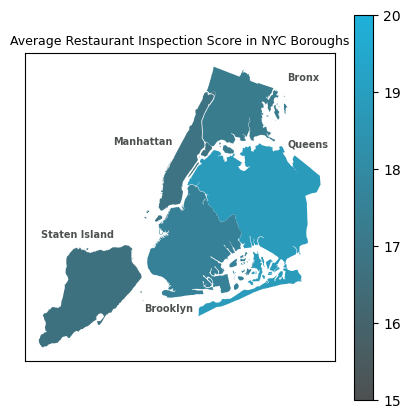

In [58]:
# Create a custom colormap for our purposes
import matplotlib.colors as mcolors
cmap_list = ['#4e5151','#1fb1db']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap',
                                                        colors=cmap_list,
                                                        N=100)
# Generate a choropleth plot of the average score in each borough
ax = nyc_boroughs.plot(column='avg_score',cmap=custom_cmap,legend=True,
                       vmin=15,vmax=20,figsize=(5,5))
plt.title('Average Restaurant Inspection Score in NYC Boroughs',fontsize=9)
fig = ax.get_figure()
plt.xticks([])
plt.yticks([])

# Add the labels
b = {'Manhattan': (-74.05, 40.805),
     'Brooklyn': (-74, 40.555),
     'Queens': (-73.725, 40.8),
     'Staten Island': (-74.18, 40.665),
     'Bronx': (-73.735, 40.9)}
for borough,(long,lat) in b.items():
    ax.text(x=long,y=lat,s=borough,ha='center',va='center',
            color='#4e5151',fontsize=7,fontweight='bold')

There does not appear to be tremendous separation between the boroughs in terms on inspection score.  As this feature does not have too many levels, we will simply leave it in our data, but we should not be surprised if it proves not to be among the most important in the modeling process.

## Text and NLP

There are two features left to engineer: the inspection type and the violation description.  The violation description will require more extensive NLP, so we will deal with that one at the end.  The inspection type simply has too many levels to pass into our model as-is with out data size and compute resources.  Thus, we will see first if there is some patterned way by which we can reduce the number of levels before joining this information to our modeling dataframe.  Fortunately, the inspection type is something that the Department of Health *would* know before conducting an inspection, so we do not have to use a window function to summarize this for past inspections.

In [59]:
# See how many unique inspection types there are
len(df['inspection_type'].unique())

24

In [60]:
# Observe a few of these to see if there is a pattern
pd.Series(df['inspection_type'].unique()).head()

0       Cycle Inspection / Initial Inspection
1            Cycle Inspection / Re-inspection
2    Pre-permit (Operational) / Re-inspection
3     Cycle Inspection / Reopening Inspection
4    Cycle Inspection / Compliance Inspection
dtype: object

It appears that there are two categories of types, separated by a slash.  We will separate these out into two features and then see which one we think may add the greatest lift to our model.  If necessary, we can keep both of them, since merely separating these out will reduce the number of features.

In [61]:
# Separate the inspection type into two features
df['inspection_type1'] = df['inspection_type'].str.split(' / ').str[0]
df['inspection_type2'] = df['inspection_type'].str.split(' / ').str[1]
df[['inspection_type','inspection_type1','inspection_type2']].head(3)

,inspection_type,inspection_type1,inspection_type2
0,Cycle Inspection / Initial Inspection,Cycle Inspection,Initial Inspection
1,Cycle Inspection / Initial Inspection,Cycle Inspection,Initial Inspection
2,Cycle Inspection / Initial Inspection,Cycle Inspection,Initial Inspection


In [62]:
# Ensure that neither of these inspection types has more than one unique value per inspection
test = df.groupby('inspection_id').agg(
    inspection_type1=('inspection_type1','nunique'),
    inspection_type2=('inspection_type2','nunique')
)
test[(test['inspection_type1']>1) | (test['inspection_type2']>1)]

,inspection_type1,inspection_type2
inspection_id,,
1690,2,1
16931,2,1
30812,2,1
34867,2,1
63595,3,1
63901,2,1


Unfortunately, it seems there are a few inspections with multiple unique inspection types.  Let's investigate these to see if we can find a pattern.

In [63]:
# Print out the unique inspection types for each of these problematic inspections
prob_rows = test[(test['inspection_type1']>1) | (test['inspection_type2']>1)]
prob_inspections = list(prob_rows.index)
for id in prob_inspections:
    print(f'Unique inspection types for inspection {id}:')
    unique_inspection_types = list(df[df['inspection_id']==id]['inspection_type'].unique())
    print(f'{unique_inspection_types}\n')

Unique inspection types for inspection 1690:
['Inter-Agency Task Force / Initial Inspection', 'Smoke-Free Air Act / Initial Inspection']

Unique inspection types for inspection 16931:
['Administrative Miscellaneous / Initial Inspection', 'Cycle Inspection / Initial Inspection']

Unique inspection types for inspection 30812:
['Pre-permit (Operational) / Initial Inspection', 'Administrative Miscellaneous / Initial Inspection']

Unique inspection types for inspection 34867:
['Administrative Miscellaneous / Re-inspection', 'Pre-permit (Operational) / Re-inspection']

Unique inspection types for inspection 63595:
['Administrative Miscellaneous / Initial Inspection', 'Calorie Posting / Initial Inspection', 'Pre-permit (Operational) / Initial Inspection']

Unique inspection types for inspection 63901:
['Administrative Miscellaneous / Initial Inspection', 'Pre-permit (Operational) / Initial Inspection']



Since the unique inspection types for each of these inspections all have the same second entry as each other, and since there are only six inspections with this issue, we will take the liberty to impute the first inspection type entry with the first one that appears for that given inspection.  This will clean the data to enable us to continue with grouping below.

In [64]:
# Impute the first inspection type to the others for these inspections
for id in prob_inspections:
    first_inspection_type = list(df[df['inspection_id']==id]['inspection_type'].unique())[0]
    df.loc[df['inspection_id']==id,'inspection_type'] = first_inspection_type
# Recreate inspection types 1 and 2
df['inspection_type1'] = df['inspection_type'].str.split(' / ').str[0]
df['inspection_type2'] = df['inspection_type'].str.split(' / ').str[1]
# Ensure that this was done correctly
test = df.groupby('inspection_id').agg(
    inspection_type1=('inspection_type1','nunique'),
    inspection_type2=('inspection_type2','nunique')
)
test[(test['inspection_type1']>1) | (test['inspection_type2']>1)]


,inspection_type1,inspection_type2
inspection_id,,


Excellent, now we are ready to group and see which inspection type (if any) could provide lift.

In [65]:
# Group the inspection grades by each and generate countplots
type1 = df.groupby(['inspection_type1','inspection_id'],as_index=False)['grade']\
    .agg(pd.Series.mode)
type2 = df.groupby(['inspection_type2','inspection_id'],as_index=False)['grade']\
    .agg(pd.Series.mode)

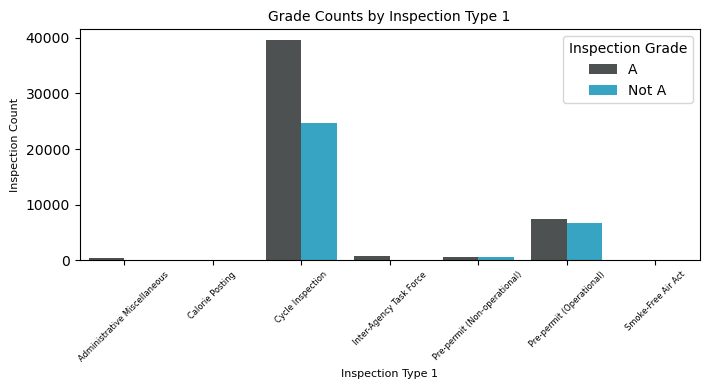

In [66]:
# Countplot for inspection type 1
plt.figure(figsize=(8,3))
sns.countplot(data=type1,x='inspection_type1',hue='grade',palette=['#4e5151','#1fb1db'])
plt.xticks(rotation=45,fontsize=6)
plt.title('Grade Counts by Inspection Type 1',fontsize=10)
plt.xlabel('Inspection Type 1',fontsize=8)
plt.ylabel('Inspection Count',fontsize=8)
plt.legend(title='Inspection Grade')
plt.show()

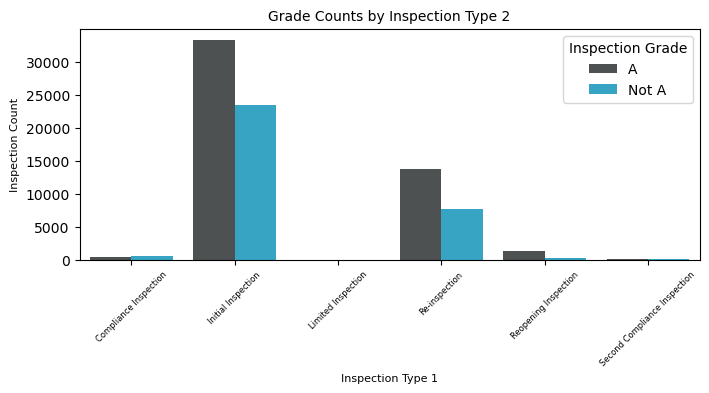

In [67]:
# Countplot for inspection type 2
plt.figure(figsize=(8,3))
sns.countplot(data=type2,x='inspection_type2',hue='grade',palette=['#4e5151','#1fb1db'])
plt.xticks(rotation=45,fontsize=6)
plt.title('Grade Counts by Inspection Type 2',fontsize=10)
plt.xlabel('Inspection Type 1',fontsize=8)
plt.ylabel('Inspection Count',fontsize=8)
plt.legend(title='Inspection Grade')
plt.show()

While neither of the above plots definitively show the potential for more lift relative to the other, they do reveal that we can definitely reduce the number of levels in each feature to three.  We will keep the two most prominent inspection types in each, and will simply collapse the others into an 'Other' category.  We will then add both inspection types 1 and 2 to our modeling data.

In [68]:
# Collapse the less frequent levels into an 'Other' level for types 1 and 2
keep_type1 = ['Cycle Inspection','Pre-permit (Operational)']
keep_type2 = ['Initial Inspection','Re-inspection']
df['inspection_type1'] = df['inspection_type1']\
    .apply(lambda x: x if x in keep_type1 else 'Other')
df['inspection_type2'] = df['inspection_type2']\
    .apply(lambda x: x if x in keep_type2 else 'Other')
# Ensure this was done correctly
for inspection_type in ['inspection_type1','inspection_type2']:
    print(f'New unique vals for {inspection_type}:')
    unique_vals = list(df[inspection_type].unique())
    print(f'{unique_vals}\n')

New unique vals for inspection_type1:
['Cycle Inspection', 'Pre-permit (Operational)', 'Other']

New unique vals for inspection_type2:
['Initial Inspection', 'Re-inspection', 'Other']



In [69]:
# Join the inspection types to our modeling data
inspection_types = df.groupby('inspection_id',as_index=False).agg(
    inspection_type1=('inspection_type1',pd.Series.mode),
    inspection_type2=('inspection_type2',pd.Series.mode)
)
df_mod = pd.merge(left=df_mod,right=inspection_types,on='inspection_id',how='left')

Now, for the violation descriptions.  We will use the nltk library to tokenize the descriptions, and they we will pull out the 40 most definitive tokens of each inspection grade.  From these, we will find the mismatched words and use these as the definitive words to distinguish inspections with non-A grades versus those with A grades.  We will then use a window function to pull in the number of such keywords that were found in a restaurant's violation descriptions over the past two years, and add this feature to our modeling data.

In [70]:
# Grab the English stopwords
stopwords_english = nltk.corpus.stopwords.words('english')
# Remove 'not' from the stopwords
stopwords_english.remove('not')
# Define a function to return tokenized text
def text_preparer(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokenized = tokenizer.tokenize(text)
    # remove the stopwords
    tokenized = [word.lower() for word in tokenized if not word in stopwords_english]
    return tokenized

In [71]:
# Tokenize the violation descriptions
df['description_tokenized'] = df['violation_description']\
    .apply(lambda x: np.nan if x=='Not Applicable' else text_preparer(x))

In [72]:
# Build out a word frequency dict for each grade
keyword_dicts = {'A':{},'Not A':{}}
for grade in keyword_dicts.keys():
    # Filter the df to only rows with that grade
    filtered = df[df['grade']==grade]
    # Retrieve all tokenized descriptions
    tokenized_descriptions = list(filtered['description_tokenized'])
    # Build out the word frequency dictionary
    for token_list in tokenized_descriptions:
        if not type(token_list)==list:
            continue
        else:
            for token in token_list:
                if not token in keyword_dicts[grade].keys():
                    keyword_dicts[grade][token] = 1
                else:
                    keyword_dicts[grade][token] += 1
    # Sort the dict in descending order
    keyword_dicts[grade] = dict(sorted(keyword_dicts[grade].items(),key=lambda item: item[1],reverse=True))

In [73]:
# Pull out the 40 most common words for both grades
a_keywords = set(list(keyword_dicts['A'].keys())[:40])
not_a_keywords = set(list(keyword_dicts['Not A'].keys())[:40])
# Find the ones that are unique to inspections receiving a non-A grade
keywords = list(not_a_keywords-a_keywords)
print(f'Number of definitive keywords: {len(keywords)}')
keywords


Number of definitive keywords: 15


['mice',
 'conducive',
 'cold',
 'free',
 'hot',
 'rodents',
 'washing',
 'areas',
 'conditions',
 'harborage',
 'hand',
 'facility',
 'insects',
 'raw',
 'live']

In [74]:
# Create a new column that counts how many of these keywords are in the violation description
def keyword_counter(token_list:list,keywords:list):
    count = 0
    for token in token_list:
        if token in keywords:
            count+=1
    return count
df['description_keywords'] = df['description_tokenized']\
    .apply(lambda x: keyword_counter(token_list=x,keywords=keywords) if type(x)==list else 0)

Finally, we will use a window function to retrieve the number of such definitive keywords found for a given restaurant's inspections over the past two years.  Then, we can join this data to our modeling data.

In [75]:
# Group the keyword counts
keywords_grouped = df.groupby('inspection_id',as_index=False).agg(
    description_keywords=('description_keywords','sum'),
    inspection_date=('inspection_date',pd.Series.mode),
    restaurant_id=('restaurant_id','median')
).set_index('inspection_date')
# Use the window function to find the keyword count in the past two years, encoding nulls as -1
windowed_keywords = keywords_grouped.groupby('restaurant_id')['description_keywords']\
    .rolling('730d',closed='left').sum().fillna(-1)\
    .rename('description_keywords_past_two_years').reset_index()
# Join this data to our modeling data
df_mod = pd.merge(left=df_mod,right=windowed_keywords,on=['restaurant_id','inspection_date'],how='left')

# EDA

Now that we have engineered all the features we will use for modeling, we can begin the EDA process.  We will start by examining the distribution of the numeric features, transforming any that are excessively skewed.

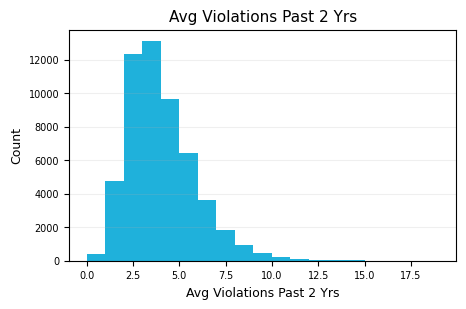

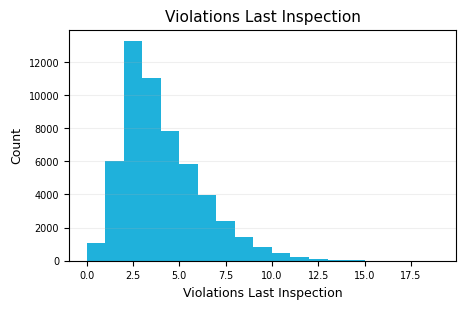

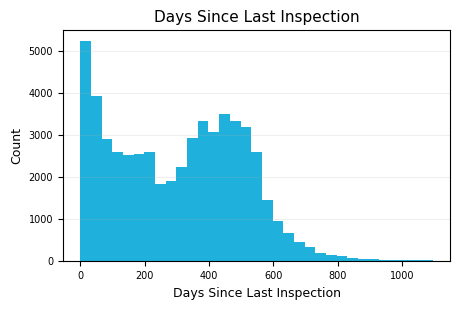

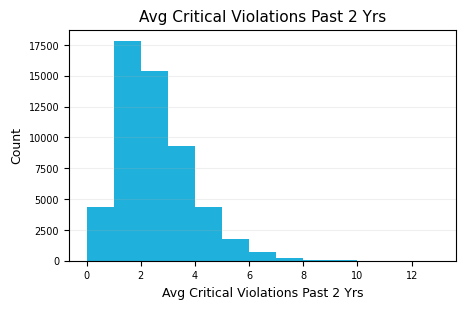

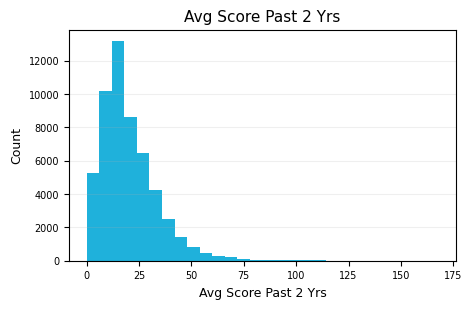

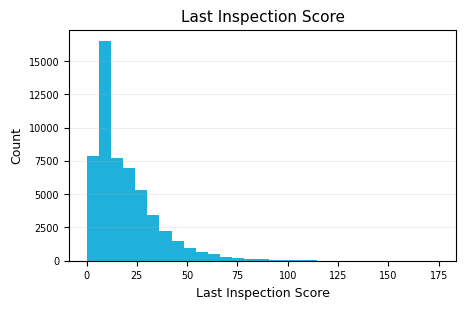

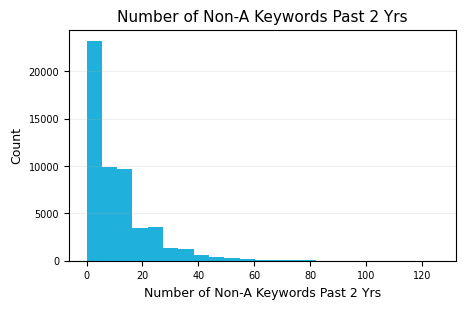

In [76]:
# Plot a histogram for each numeric column of interest
num_cols = {
    'avg_violations_past_two_years':'Avg Violations Past 2 Yrs',
    'violations_last_inspection':'Violations Last Inspection',
    'days_since_last':'Days Since Last Inspection',
    'avg_critical_violations_past_two_years':'Avg Critical Violations Past 2 Yrs',
    'avg_score_past_two_years':'Avg Score Past 2 Yrs',
    'last_score':'Last Inspection Score',
    'description_keywords_past_two_years':'Number of Non-A Keywords Past 2 Yrs'
}
for col,lab in num_cols.items():
    data = df_mod[df_mod[col]!=-1]  # filter out nulls encoded as -1
    # Determine an appropriate number of bins
    col_range = data[col].max() - data[col].min()
    if col_range<=25:
        bin_range = int(np.ceil(col_range))
        bins = list(range(bin_range+1))
    elif col_range>=200:
        bins = int(np.round(col_range**.5,0))
    else:
        bins = int(np.round(col_range**.65,0))
    # Generate the histogram
    plt.figure(figsize=(5,3))
    data[col].plot(kind='hist',bins=bins,color='#1fb1db')
    plt.title(lab,fontsize=11)
    plt.xlabel(lab,fontsize=9)
    plt.ylabel('Count',fontsize=9)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().yaxis.grid(True,alpha=.2)
    plt.show()

We will go ahead and log transform the columns that appeared the most heavily skewed.

In [77]:
# Log transform the specified columns
to_transform = [
    'avg_score_past_two_years',
    'last_score',
    'description_keywords_past_two_years'
]
for col in to_transform:
    new_colname = 'log_'+col
    df_mod[new_colname] = df_mod[col]\
        .apply(lambda x: x if x in [-1,0] else np.log(x))
    df_mod = df_mod.drop(col,axis=1)

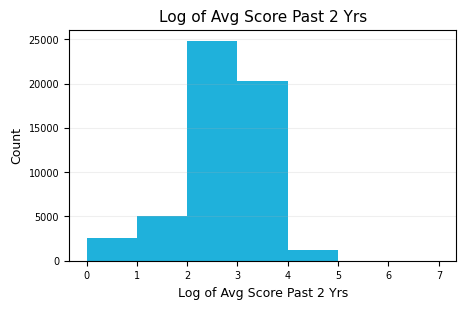

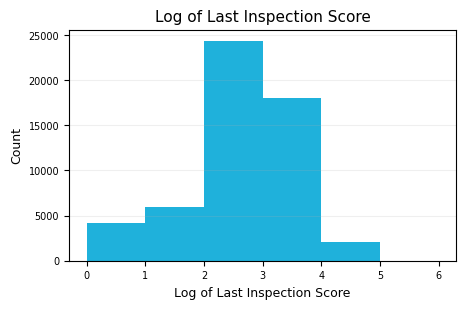

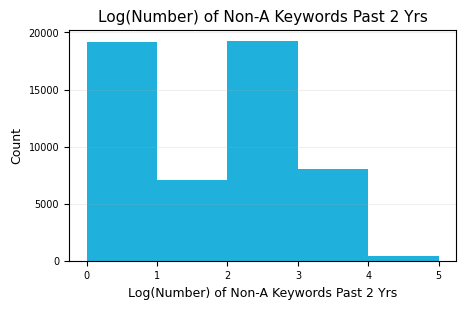

In [78]:
# Plot a histogram for each numeric column of interest
log_cols = {
    'log_avg_score_past_two_years':'Log of Avg Score Past 2 Yrs',
    'log_last_score':'Log of Last Inspection Score',
    'log_description_keywords_past_two_years':'Log(Number) of Non-A Keywords Past 2 Yrs'
}
for col,lab in log_cols.items():
    data = df_mod[df_mod[col]!=-1]  # filter out nulls encoded as -1
    # Determine an appropriate number of bins
    col_range = data[col].max() - data[col].min()
    if col_range<=25:
        bin_range = int(np.ceil(col_range))
        bins = list(range(bin_range+1))
    elif col_range>=200:
        bins = int(np.round(col_range**.5,0))
    else:
        bins = int(np.round(col_range**.65,0))
    # Generate the histogram
    plt.figure(figsize=(5,3))
    data[col].plot(kind='hist',bins=bins,color='#1fb1db')
    plt.title(lab,fontsize=11)
    plt.xlabel(lab,fontsize=9)
    plt.ylabel('Count',fontsize=9)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.gca().yaxis.grid(True,alpha=.2)
    plt.show()

Next, we will turn our attention to multicollinearity.  Given how intuitively related many of the features are that we engineered, we should not be surprised to see many high correlations here.  The tree-based methods we plan to use should account for these by building the interactions into the trees.  Regularization on the logistic regression should also help with the problem there.  For now, we are just going to examine the correlations; during the modeling phase, we can decide if any extra steps need to be taken to address the problem.

In [79]:
# Retrieve a list of the columns we want to use to generate our correlation heatmap
corr_cols = [
    'grade',
    'is_chain',
    'closed_past_two_years',
    'avg_violations_past_two_years',
    'violations_last_inspection',
    'last_grade',
    'days_since_last',
    'avg_critical_violations_past_two_years',
    'inspection_risk_area',
    'log_avg_score_past_two_years',
    'log_last_score',
    'log_description_keywords_past_two_years'
]
# Create a copy of the df with just those columns
corr_df = df_mod[corr_cols]
# If the column is not already numeric, factorize it
num_cols = list(corr_df.select_dtypes('number').columns)
for col in list(corr_df.columns):
    if col not in num_cols:
        codes,uniques = pd.factorize(corr_df[col])
        corr_df[col] = codes

C:\Users\seanm\AppData\Local\Temp\ipykernel_24852\4148469250.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df[col] = codes
C:\Users\seanm\AppData\Local\Temp\ipykernel_24852\4148469250.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df[col] = codes
C:\Users\seanm\AppData\Local\Temp\ipykernel_24852\4148469250.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

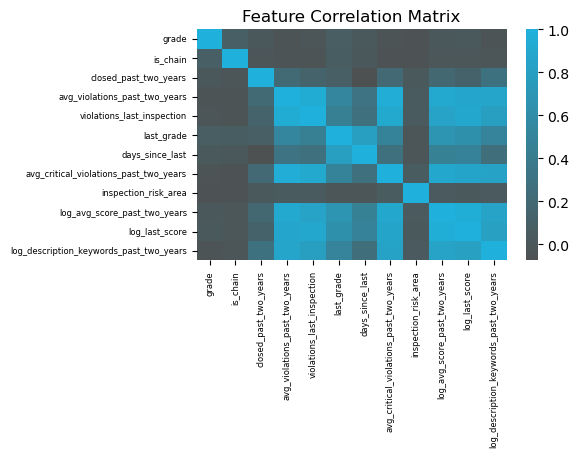

In [80]:
# Generate the correlation matrix heatmap
plt.figure(figsize=(5,3))
sns.heatmap(data=corr_df.corr(),cmap=custom_cmap)
plt.title('Feature Correlation Matrix')
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

Next, we will see how a few select categorical features are related with the inspection scores

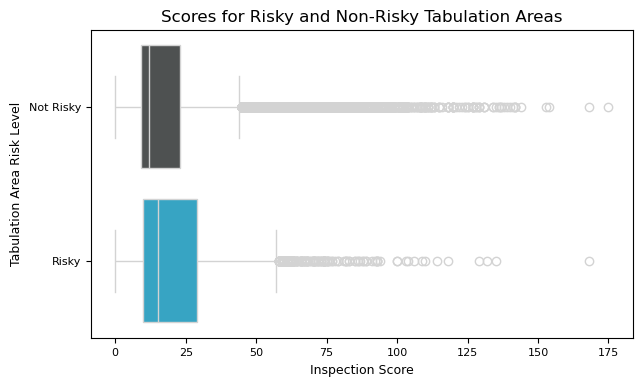

In [81]:
# Create the boxplot for risky tabulation areas
data = df_mod.copy()
data['risk'] = data['inspection_risk_area'].map({0:'Not Risky',1:'Risky'})
plt.figure(figsize=(7,4))
sns.boxplot(data=data,
            x='score',
            y='risk',
            hue='risk',
            palette=['#4e5151','#1fb1db'],
            linewidth=1,
            linecolor='lightgray')
plt.title('Scores for Risky and Non-Risky Tabulation Areas')
plt.xlabel('Inspection Score',fontsize=9)
plt.ylabel('Tabulation Area Risk Level',fontsize=9)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.show()

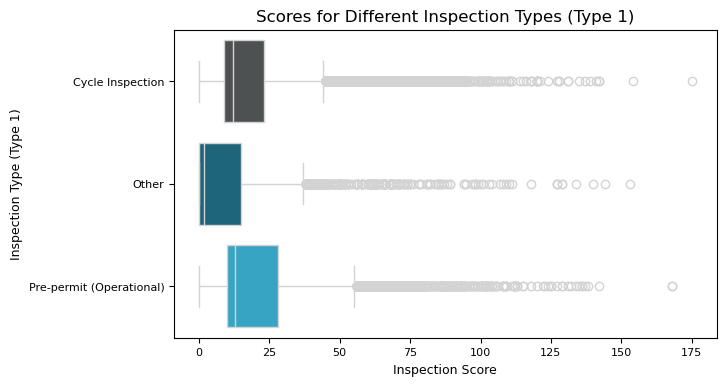

In [82]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df_mod,
            x='score',
            y='inspection_type1',
            hue='inspection_type1',
            palette=['#4e5151',"#106e88",'#1fb1db'],
            linewidth=1,
            linecolor='lightgray')
plt.title('Scores for Different Inspection Types (Type 1)')
plt.xlabel('Inspection Score',fontsize=9)
plt.ylabel('Inspection Type (Type 1)',fontsize=9)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.show()

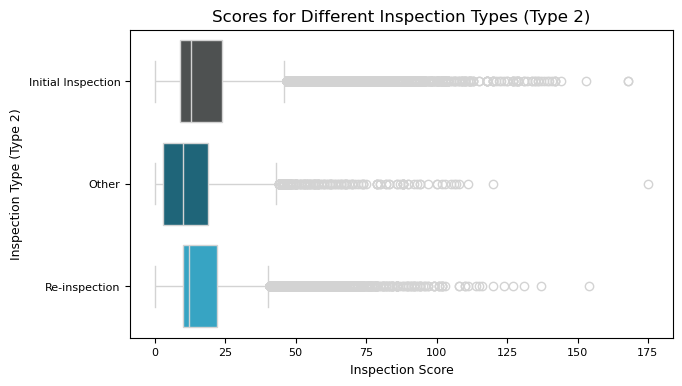

In [83]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df_mod,
            x='score',
            y='inspection_type2',
            hue='inspection_type2',
            palette=['#4e5151',"#106e88",'#1fb1db'],
            linewidth=1,
            linecolor='lightgray')
plt.title('Scores for Different Inspection Types (Type 2)')
plt.xlabel('Inspection Score',fontsize=9)
plt.ylabel('Inspection Type (Type 2)',fontsize=9)
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.show()

Finally, we will use the keywords we pulled out before that distinguish non-A grade inspections from A grade inspections, and generate a wordcloud to visualize the characteristic words from these violation descriptions.

In [84]:
# Get text string of all keywords with each appearing as many times as it is in the keyword dict
wordcloud_dict = {}
mega_string = ''
for word in list(keyword_dicts['Not A'].keys())[:30]:
    wordcloud_dict[word] = keyword_dicts['Not A'][word]
for word,reps in wordcloud_dict.items():
    mega_string += f'{word} '*reps
mega_string = mega_string[:-1]  # remove the last trailing space

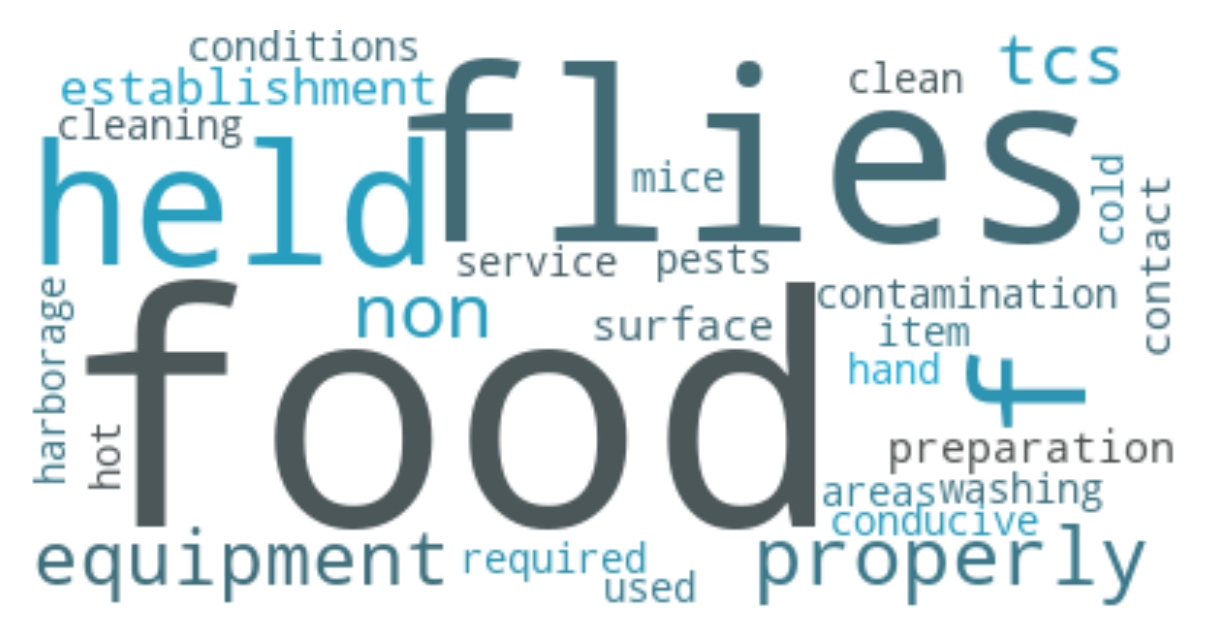

In [85]:
# Generate the word cloud from our mega string
wordcloud = WordCloud(width=400,height=200,margin=1,background_color='white',
                      colormap=custom_cmap,collocations=False)\
    .generate(mega_string)
plt.figure(figsize=(5,5),dpi=300)
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Save Modeling Data

Finally, we will go ahead and save our modeling data to a .csv file so we can load it in in the modeling notebook.

In [86]:
# Save our cleaned modeling data to a .csv file
df_mod.to_csv('../data/Modeling_Data.csv',index=False)